### 1. Preprocess the data such as highly-variable gene filtering

See https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html for preprocessing

Use dandelion/dandelion/preprocessing/external/_preprocessing.py/recipe_scannpy_qc function to do preprocessing

<span style="color:yellow">**Attemp 1:**</span> filter multiple AnnData objects from 3 datasets

In [1]:
# Environment set-up
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import scipy as scipy
import seaborn as sbn
import matplotlib.pyplot as plt
from dandelion.preprocessing.external._preprocessing import recipe_scanpy_qc

import warnings
warnings.filterwarnings("ignore")

In [12]:
# Check the gene names of Anndata objects

from pathlib import Path

GSE132509_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')
for file_path in GSE132509_directory.iterdir():
    if "_uni.h5ad" in file_path.name:
        adata1 = anndata.read_h5ad(file_path)
        list1 = [gene for gene in adata1.var_names]
        print(list1)
        break

GSE236351_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE236351')
for file_path in GSE236351_directory.iterdir():
    if "_uni.h5ad" in file_path.name:
        adata2 = anndata.read_h5ad(file_path)
        list2 = [gene for gene in adata2.var_names]
        print(list2)
        break

GSE148218_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE148218')
for file_path in GSE148218_directory.iterdir():
    if "_uni.h5ad" in file_path.name:
        adata3 = anndata.read_h5ad(file_path)
        list3 = [gene for gene in adata3.var_names]
        print(list3)
        break

# Use sets to find the intersections of these gene symbols
set1 = set(list1)
set2 = set(list2)
set3 = set(list3)

# Check if there are duplicates in gene names
print("The number of total genes: ", len(list1), len(list2), len(list3))
print("The number of unique genes: ", len(set1), len(set2), len(set3))

common_genes = set1.intersection(set2, set3)
print("The number of common genes: ", len(common_genes))
print(common_genes)

['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8', 'RP11-34P13.14', 'RP11-34P13.9', 'FO538757.3', 'FO538757.2', 'AP006222.2', 'RP5-857K21.15', 'RP4-669L17.2', 'RP4-669L17.10', 'OR4F29', 'RP5-857K21.4', 'RP5-857K21.2', 'OR4F16', 'RP11-206L10.4', 'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C', 'RP11-54O7.16', 'RP11-54O7.1', 'RP11-54O7.2', 'RP11-54O7.3', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'RP11-54O7.17', 'HES4', 'ISG15', 'RP11-54O7.11', 'AGRN', 'RP11-54O7.18', 'RNF223', 'C1orf159', 'LINC01342', 'RP11-465B22.8', 'TTLL10-AS1', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'FAM132A', 'RP5-902P8.12', 'UBE2J2', 'RP5-902P8.10', 'SCNN1D', 'ACAP3', 'PUSL1', 'CPSF3L', 'CPTP', 'TAS1R3', 'DVL1', 'MXRA8', 'AURKAIP1', 'CCNL2', 'MRPL20', 'RP4-758J18.13', 'ANKRD65', 'RP4-758J18.7', 'TMEM88B', 'RP4-758J18.10', 'VWA1', 'ATAD3C', 'ATAD3B', 'ATAD3A', 'TMEM240', 'SSU72', 'RP5-832C2.5', 'AL645728.1', 'C1orf233', 'RP11-345P4.9', 'MIB2', 'MMP23B', 'CDK11B', 'RP11-345P4.10

In [2]:
# Do the preprocessing

from pathlib import Path
from itertools import chain

GSE132509_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')
GSE236351_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE236351')
# GSE148218_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE148218')
# GSE235923_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE235923')

combined_dirs = chain(GSE132509_directory.iterdir(), GSE236351_directory.iterdir())

# Use a dictionary to store AnnData objects (Key: sample_name, Value: filtered_anndata)
adatas = {} 

for adata_path in combined_dirs:
    if "_uni.h5ad" in adata_path.name:
        adata = anndata.read_h5ad(adata_path)
        adata.raw = adata
        print(adata_path.stem)
        print(adata.shape)

        # Do QC and filtering
        recipe_scanpy_qc(adata)
        adata = adata[adata.obs.filter_rna == 'False', :]
        print(adata.shape)

        # Do normalization
        sc.pp.normalize_total(adata, target_sum=1.0)

        # Do the log transformation
        sc.pp.log1p(adata)

        # # Select highky-variable genes
        # sc.pp.highly_variable_genes(
        #     adata,
        #     n_top_genes=2000,
        # )
        # adata = adata[:, adata.var.highly_variable]
        # print(adata.shape)

        # Do the scaling
        sc.pp.scale(adata, max_value=10)

        adatas[adata_path.stem] = adata

GSM3872444_PBMMC_3_uni
(2229, 33694)
(302, 33694)
GSM3872442_PBMMC_1_uni
(1612, 33694)
(1242, 33694)
GSM3872441_PRE-T_2_uni
(2748, 33694)
(1053, 33694)
GSM3872443_PBMMC_2_uni
(3105, 33694)
(2162, 33694)
GSM3872437_ETV6-RUNX1_4_uni
(5069, 33694)
(3465, 33694)
GSM3872438_HHD_1_uni
(3728, 33694)
(3249, 33694)
GSM3872439_HHD_2_uni
(5013, 33694)
(2373, 33694)
GSM3872435_ETV6-RUNX1_2_uni
(6274, 33694)
(4227, 33694)
GSM3872434_ETV6-RUNX1_1_uni
(2776, 33694)
(2525, 33694)
GSM3872440_PRE-T_1_uni
(2959, 33694)
(2541, 33694)
GSM3872436_ETV6-RUNX1_3_uni
(3862, 33694)
(1196, 33694)
GSM7528330_M6_uni
(1712, 17950)
(1270, 17950)
GSM7528331_M7_uni
(6916, 36601)
(6488, 36601)
GSM7528326_M2_uni
(6523, 36601)
(5074, 36601)
GSM7528328_M4_uni
(3731, 17950)
(3462, 17950)
GSM7528329_M5_uni
(3726, 17950)
(2450, 17950)
GSM7528327_M3_uni
(2942, 17950)
(2459, 17950)
GSM7528325_M1_uni
(4293, 17950)
(4115, 17950)


### 2. Integration with Scanorama

See https://github.com/brianhie/scanorama for more info

In [3]:
import scanorama

# Obtain the anndata objs list
adatas_list = [adata for adata in adatas.values()]
print(len(adatas_list))

# Integration and batch correction.
corrected = scanorama.correct_scanpy(adatas_list, return_dimred=True)

18
Found 14718 genes among all datasets
[[0.00000000e+00 6.05960265e-01 3.50993377e-01 5.96026490e-02
  1.65562914e-01 2.81456954e-01 1.95364238e-01 1.55629139e-01
  6.95364238e-02 6.62251656e-02 4.96688742e-02 2.48344371e-01
  1.12582781e-01 1.32450331e-02 3.64238411e-02 8.27814570e-02
  6.29139073e-02 1.22516556e-01]
 [0.00000000e+00 0.00000000e+00 2.09339775e-01 1.23188406e-01
  3.70370370e-02 3.57487923e-01 3.62318841e-02 6.84380032e-02
  2.81803543e-02 3.22061192e-02 7.24637681e-03 1.95275591e-01
  6.03864734e-02 3.70370370e-02 4.42834138e-02 4.42834138e-02
  7.48792271e-02 2.01288245e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.41880342e-02
  2.46913580e-02 3.66571700e-01 2.34567901e-01 2.33618234e-01
  1.88983856e-01 4.11206078e-01 3.22886990e-02 2.92913386e-01
  2.32668566e-01 2.37416904e-02 2.74453941e-01 1.11111111e-01
  3.70370370e-02 9.21177588e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.72247919e-01 1.06382979e-02 9.25069380e-04 4.162812

In [4]:
# Concatenate the integrated AnnData objects
adata_integrated = sc.AnnData.concatenate(*corrected)
print(adata_integrated)

AnnData object with n_obs × n_vars = 49653 × 14718
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'mean-0', 'std-0', 'gene_ids-1', 'mean-1', 'std-1', 'gene_ids-10', 'mean-10', 'std-10', 'gene_ids-11', 'mean-11', 'std-11', 'feature_types-11', 'gene_ids-12', 'mean-12', 'std-12', 'feature_types-12', 'gene_ids-13', 'mean-13', 'std-13', 'feature_types-13', 'gene_ids-14', 'mean-14', 'std-14', 'feature_types-14', 'gene_ids-15', 'mean-15', 'std-15', 'feature_types-15', 'gene_ids-16', 'mean-16', 'std-16', 'feature_types-16', 'gene_ids-17', 'mean-17', 'std-17', 'feature_types-17', 'gene_ids-2', 'mean-2', 'std-2', 'gene_ids-3', 'mean-3', 'std-3', 'gene_ids-4', 'mean-4', 'std-4', 'gene_ids-5', 'mean-5', 'std-5', 'gene_ids-6', 'mean-6', 'std-6', 'gene_ids-7', 'mean-7', 'std-7', 'gene_ids-8', 'mean

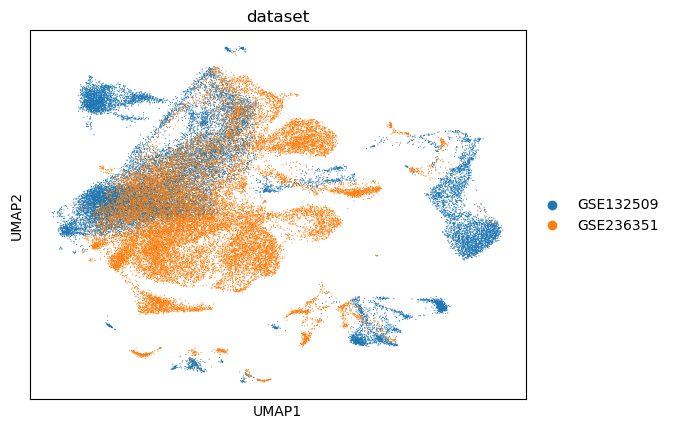

In [5]:
# Another way to do UMAP by computing KNN graph first

sc.pp.neighbors(adata_integrated, use_rep='X_scanorama', n_neighbors=10)
sc.tl.umap(adata_integrated)
sc.pl.umap(adata_integrated, color=['dataset'])

In [6]:
adata_integrated

AnnData object with n_obs × n_vars = 49653 × 14718
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'mean-0', 'std-0', 'gene_ids-1', 'mean-1', 'std-1', 'gene_ids-10', 'mean-10', 'std-10', 'gene_ids-11', 'mean-11', 'std-11', 'feature_types-11', 'gene_ids-12', 'mean-12', 'std-12', 'feature_types-12', 'gene_ids-13', 'mean-13', 'std-13', 'feature_types-13', 'gene_ids-14', 'mean-14', 'std-14', 'feature_types-14', 'gene_ids-15', 'mean-15', 'std-15', 'feature_types-15', 'gene_ids-16', 'mean-16', 'std-16', 'feature_types-16', 'gene_ids-17', 'mean-17', 'std-17', 'feature_types-17', 'gene_ids-2', 'mean-2', 'std-2', 'gene_ids-3', 'mean-3', 'std-3', 'gene_ids-4', 'mean-4', 'std-4', 'gene_ids-5', 'mean-5', 'std-5', 'gene_ids-6', 'mean-6', 'std-6', 'gene_ids-7', 'mean-7', 'std-7', 'gene_ids-8', 'mean